In [1]:
import pyspark.pandas as ps
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
from pyspark.sql import SparkSession
import seaborn as sns


# Load spaCy's pre-trained model for English
nlp = spacy.load('en_core_web_md')

spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","28g").getOrCreate()

# categories = ['AMAZON_FASHION', 'All_Beauty', 'Appliances' , 'Arts_Crafts_and_Sewing' , 'Automotive', 'Books', 'CDs_and_Vinyl', 'Cell_Phones_and_Accessories', 'Clothing_Shoes_and_Jewelry', 'Digital_Music', 'Electronics', 'Gift_Cards', 'Grocery_and_Gourmet_Food', 'Home_and_Kitchen', 'Industrial_and_Scientific', 'Kindle_Store', 'Luxury_Beauty', 'Magazine_Subscriptions', 'Movies_and_TV', 'Musical_Instruments', 'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies', 'Prime_Pantry', 'Software', 'Sports_and_Outdoors', 'Tools_and_Home_Improvement', 'Toys_and_Games', 'Video_Games']
categories = ['AMAZON_FASHION',"Appliances", 'All_Beauty', "Gift_Cards"]

/home/allorenz/.cache/pypoetry/virtualenvs/tu-dopp-ws23-U-ympmBJ-py3.11/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/21 22:07:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/21 22:07:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
def clean_text(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    
    return lemmatized_text

entitiy_proportions = ps.DataFrame()
word_counts_by_category = {}

for category in categories:
    print(f'Processing {category}')
    global entitiy_label_counter
    entitiy_label_counter = Counter()
    word_counter = Counter()
    

    df = ps.read_parquet(f'/data/{category}.parquet', index_col=['reviewerID', 'asin'])
    df = df[["reviewText", "overall", "vote"]].sample(frac=0.001)
    
    for index, row in df.iterrows():
        text = row["reviewText"]
        doc = nlp(str(text))
        
        lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
        doc = nlp(lemmatized_text)
        
        # entity label count
        temp_counts = Counter([ent.label_ for ent in doc.ents])
        entitiy_label_counter.update(temp_counts)

        # word count
        word_counter.update([token.lemma_ for token in doc if not token.is_stop])


    # manage and store entity counts
    sum_of_label_counts = sum(entitiy_label_counter.values())
    normalized_label_counts = {key: value / sum_of_label_counts for key, value in entitiy_label_counter.items()}
    
    df_normalized_label_counts_by_category = ps.DataFrame(list(normalized_label_counts.items()), columns=['Entity Label', 'Normalized Count'])
    df_normalized_label_counts_by_category["category"] = category

    entitiy_proportions = ps.concat([entitiy_proportions, df_normalized_label_counts_by_category], ignore_index=True)

    
    # Store word counts for the category
    word_counts_by_category[category] = word_counter


    

# Pivot the DataFrame for stacked horizontal barplot
stacked_df = entitiy_proportions.pivot(index='category', columns='Entity Label', values='Normalized Count')




Processing AMAZON_FASHION


24/01/21 22:08:03 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Processing Appliances


Processing All_Beauty
Processing Gift_Cards


### Wordcloud
Our assumption is that nouns, verbs, and adjectives might carry and reflect the most information about certain aspects of a product. A Wordcloud for each categoryy of top used part-of-speech is created to derive the most important aspects in each category.

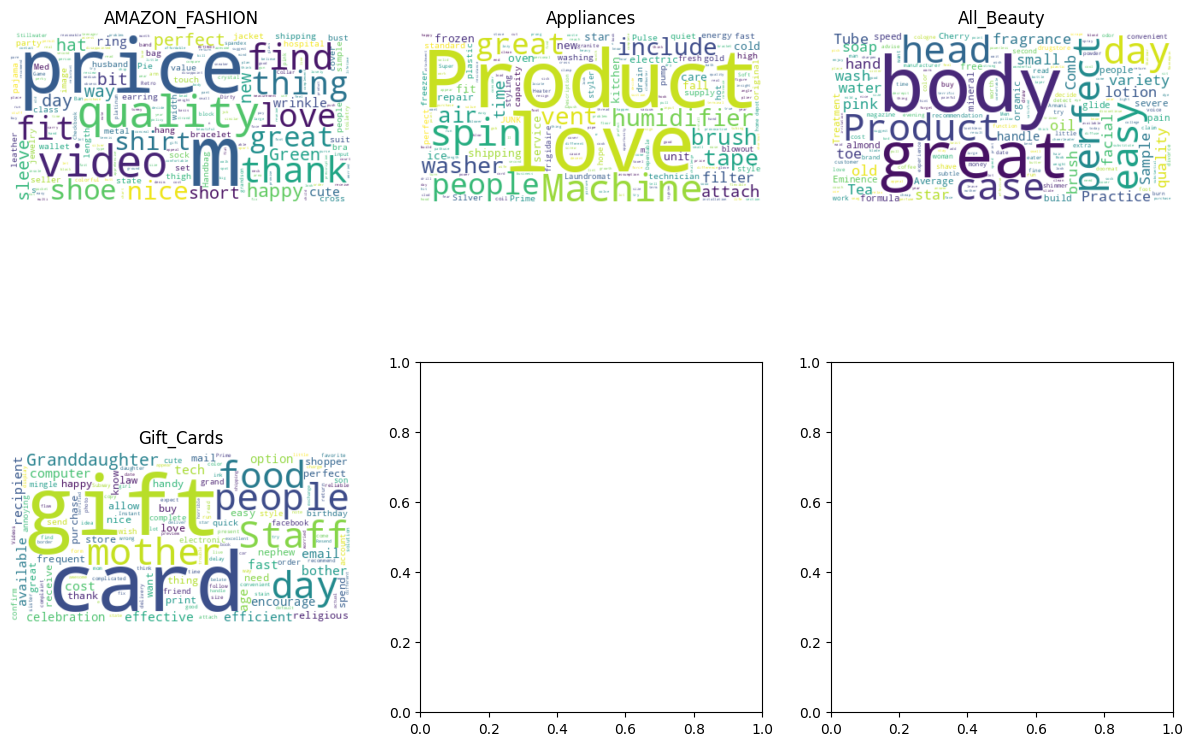

In [3]:
# Filter out only nouns, verbs, and adjectives
filtered_word_counts = {}
for category, word_counter in word_counts_by_category.items():
    filtered_words = []
    for word in word_counter.keys():
        doc = nlp(word)
        # Check if the word is a noun, verb, or adjective
        if any(token.pos_ in {'NOUN', 'VERB', 'ADJ'} for token in doc):
            filtered_words.append(word)
    
    filtered_word_counts[category] = {word: word_counter[word] for word in filtered_words}

# Plot the WordCloud images for each category
categories = list(filtered_word_counts.keys())
num_categories = len(categories)
plots_per_row = 3
num_rows = (num_categories + plots_per_row - 1) // plots_per_row  # Ceiling division to calculate rows

fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(15, 5*num_rows))

for i in range(num_rows):
    for j in range(plots_per_row):
        index = i * plots_per_row + j
        if index < num_categories:
            category = categories[index]
            word_counter = filtered_word_counts[category]

            wordcloud_text = " ".join(word_counter.keys())
            wordcloud = WordCloud(width=400, height=200, background_color='white').generate(wordcloud_text)

            axs[i, j].imshow(wordcloud, interpolation='bilinear')
            axs[i, j].set_title(category)
            axs[i, j].axis('off')

plt.show()


### Name Entity Recognition
NER shall help to identify and classify entities within the reviews by certain categories, to enhance our understanding of the mentioned aspects.
For evaluation, the proportion of referenced entities within each product category is estimated. The spaCy library is used, which has built-in recognition that encompasses 18 different entities. To inspect all possible labels, use the following code:
`nlp.get_pipe("ner").labels`

/home/allorenz/.cache/pypoetry/virtualenvs/tu-dopp-ws23-U-ympmBJ-py3.11/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<Figure size 1000x600 with 0 Axes>

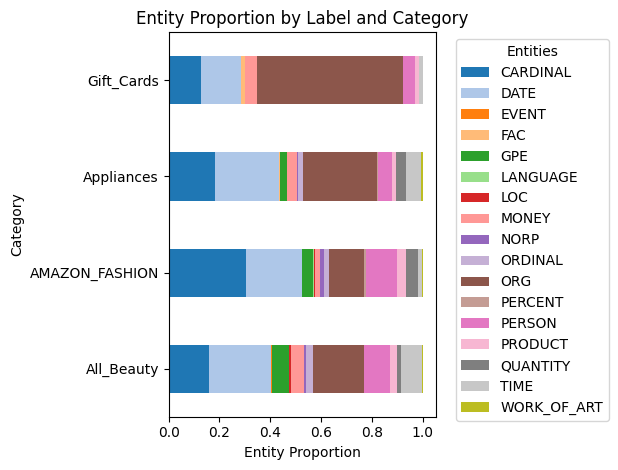

In [4]:
# Create a stacked horizontal barplot
sns.set_palette("tab20")
plt.figure(figsize=(10, 6))
stacked_df.to_pandas().plot(kind='barh', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Entities')
plt.title('Entity Proportion by Label and Category')
plt.xlabel("Entity Proportion")
plt.ylabel("Category")
plt.tight_layout()
plt.show()